# Email Phising Detector

### Overview

This notebook presents a detailed overview of this data, diving into different data visualisation techniques.
Ultimately resulting in using a ML model to predict if an email is a phishing email or not.

## Setup

In [11]:
import ipykernel

In [12]:
import pandas as pd, matplotlib, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv("email_phishing_data.csv")
df.head()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,phishing
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0


In [14]:
df["log_num_words"] = np.log1p(df["num_words"])

phishing_emails = df[df["phishing"] == 1]
non_phishing_emails = df[df["phishing"] == 0]

## Visualisation

### Histogram: Urgent Keywords Count

<Axes: title={'center': 'Distribution of Number of Urgent Words in Phishing Emails'}, xlabel='Number of Urgent Words', ylabel='Density'>

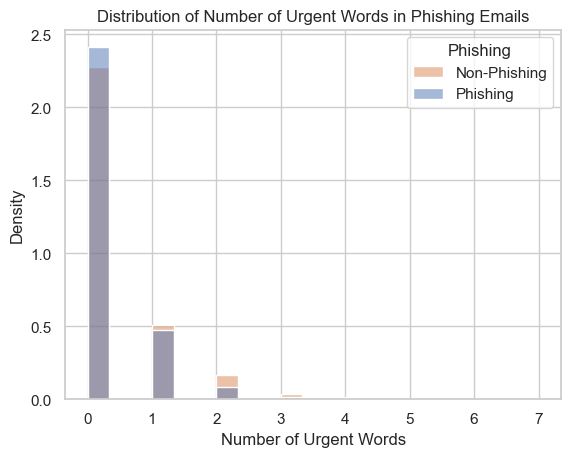

In [42]:
# Plotting the distribution of the number of urgent keywords in phishing emails
plot = sns.histplot(data=df,
                    x="num_urgent_keywords",
                    hue="phishing",
                    stat="density",
                    common_norm=False)

plot.set_title("Distribution of Number of Urgent Words in Phishing Emails")
plot.set_xlabel("Number of Urgent Words")
plot.set_ylabel("Density")
plot.legend(title="Phishing", loc="upper right", labels=["Non-Phishing", "Phishing"])
plot

### Histogram: Word Count Distribution

In [17]:
# Check for missing or zero values in the num_words column
df["num_words"].describe()

count    5.248460e+05
mean     2.762280e+02
std      3.335457e+03
min      0.000000e+00
25%      4.700000e+01
50%      1.200000e+02
75%      2.690000e+02
max      2.339682e+06
Name: num_words, dtype: float64

From the distribution shown above, we can see that there is a large interquartile range, with a strong outlier as a max value. I'll now sort the num_words column to see the high end of the spectrum

In [46]:
df["num_words"].sort_values(ascending=False).head(10)

518898    2339682
111750     103407
357879     101796
316618      63501
316072      55145
316615      49961
316164      46124
316178      45654
254930      42844
74046       41250
Name: num_words, dtype: int64

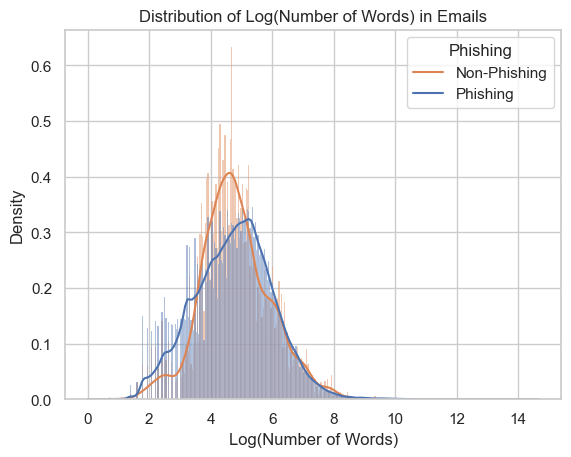

In [45]:
plot = sns.histplot(data=df,
                    x="log_num_words",
                    hue="phishing",
                    #bins=70,
                    stat="density",
                    common_norm=False,
                    kde=True
                    )

plot.set_xlabel("Log(Number of Words)")
plot.set_ylabel("Density")
plot.set_title("Distribution of Log(Number of Words) in Emails")
plot.legend(title="Phishing", loc="upper right", labels=["Non-Phishing", "Phishing"])

### Boxplots: Comparing Features by Class

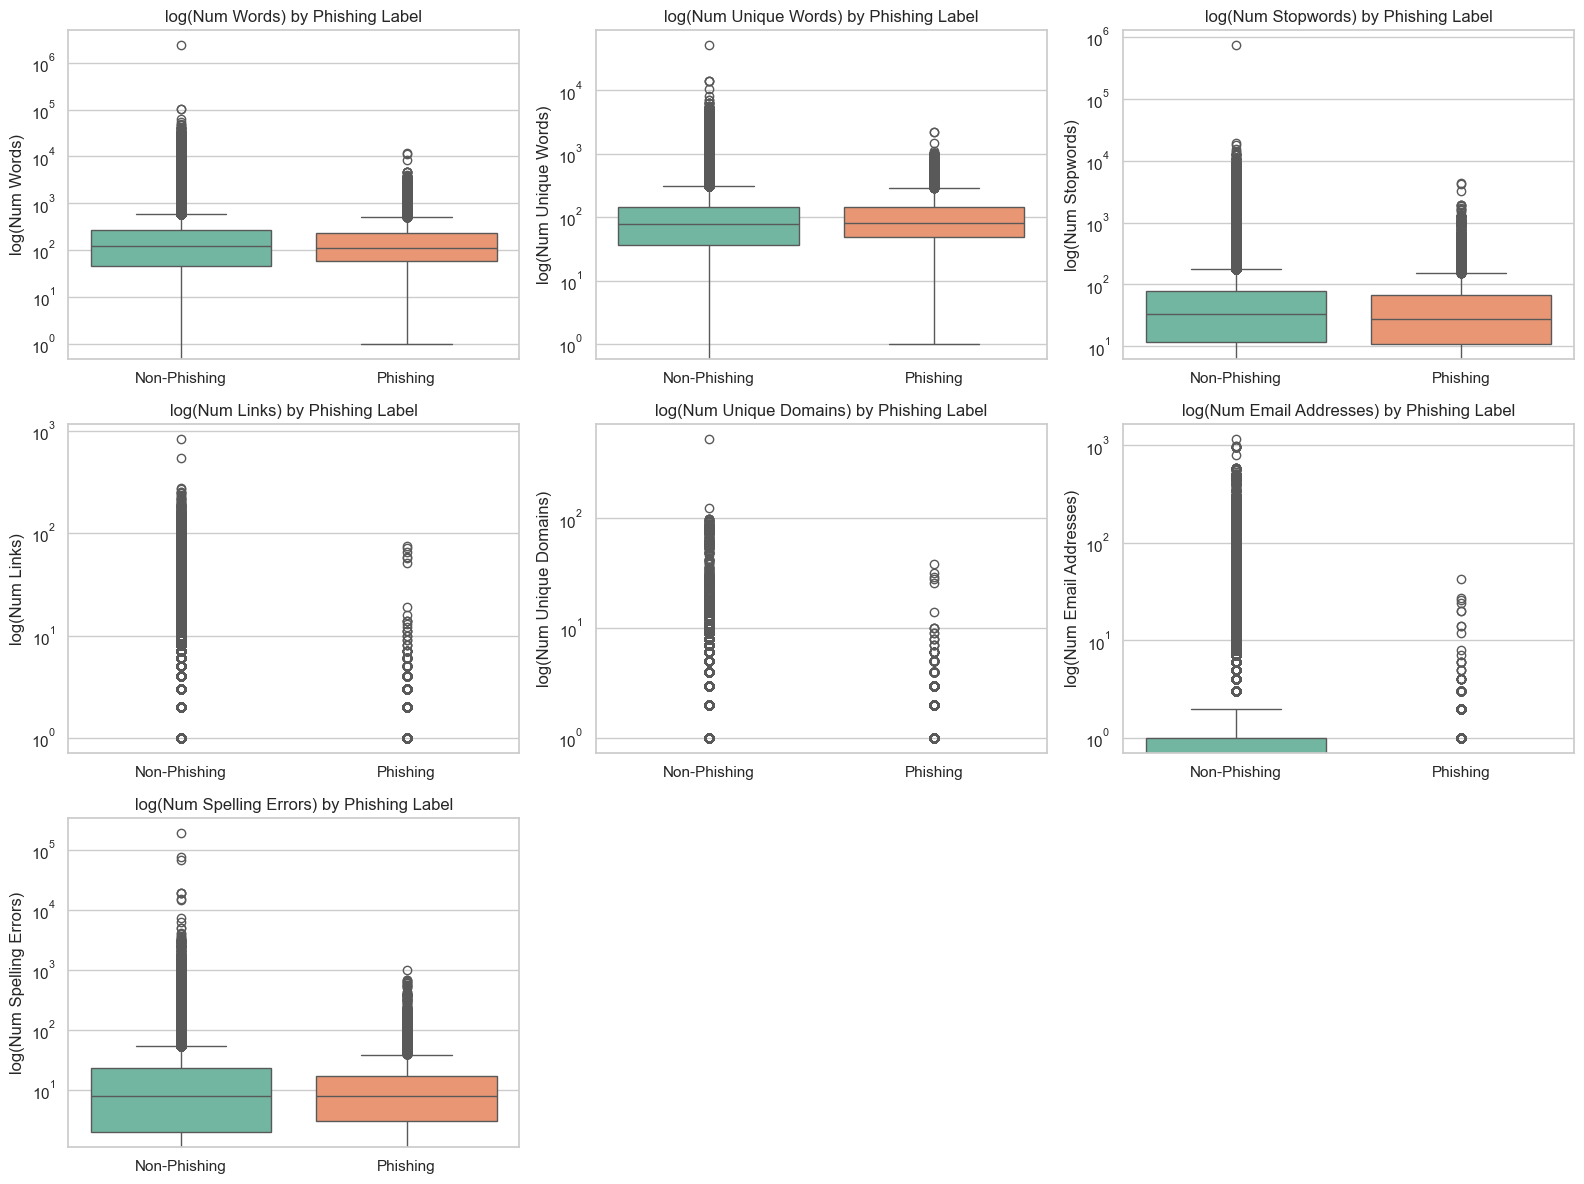

In [54]:
# Optional: set seaborn theme
sns.set_theme(style="whitegrid")

# List of features you want to visualize (excluding the target column)
features = [
    "num_words",
    "num_unique_words",
    "num_stopwords",
    "num_links",
    "num_unique_domains",
    "num_email_addresses",
    "num_spelling_errors",
]
#features = ["num_unique_words"]

# Set up the plot grid
plt.figure(figsize=(16, 12))

# Plot one boxplot per feature
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x="phishing", y=feature, palette="Set2", hue="phishing", legend=False)
    feature = feature.replace("_", " ").title()
    plt.xticks([0, 1], ["Non-Phishing", "Phishing"])
    plt.title(f"log({feature}) by Phishing Label")
    plt.xlabel("")
    plt.ylabel(f"log({feature})")
    plt.yscale("log")

plt.tight_layout()
# Save the plot to a file
plt.savefig("boxplots_by_phishing_label.png", dpi=300, bbox_inches="tight")
plt.show()


##### Conclusions from these results

1) Num Words / Unique Words / Stopwords
    * Phishing emails tend to be slightly shorter on average — the boxes are slightly lower in position.
    * The spread is very wide for both classes, but non-phishing emails seem to have more extreme outliers with very large word counts.
    * The number of stopwords follows a similar trend: phishing emails may use fewer filler/common words.

Interpretation:
Phishing emails might be more concise or templated, while legit emails can vary more in length and vocabulary richness.

2) Num Links
    * Surprisingly, non-phishing emails have more links on average — or at least a larger range and higher upper outliers.
    * Phishing emails have a tighter distribution, often with fewer links.

Interpretation:
This could indicate modern phishing attempts are being more subtle with fewer links, or that non-phishing emails (like newsletters) naturally include many links.

3) Num Unique Domains
    * Again, non-phishing emails show more variety, with a wider range and higher medians.
    * Phishing emails are more compact and have fewer unique domains.

Interpretation:
Phishing emails may target one site or spoof one domain, while legit emails often include multiple domains (e.g., images, links, assets).

4) Num Email Addresses
    * The distribution is quite similar, but phishing emails have more zero or low values.
    * Non-phishing emails might mention more email addresses (e.g., CC/BCC, signatures).

Interpretation:
Legitimate emails can involve multiple people or addresses; phishing emails may keep this simple to avoid detection.

5) Num Spelling Errors
    * Phishing emails have slightly more spelling errors, though again the spread is large.
    * There's an overlap, but phishing emails show a small shift toward more errors.

Interpretation:
This aligns with a known phishing trait - attackers may be non-native speakers, or deliberately include errors to filter out more skeptical readers.

#### Overall Patterns
* Many phishing features cluster toward lower values, suggesting they may be more "minimalist."
* Non-phishing emails are more variable and richer across several metrics.
* Spelling errors and word usage could be stronger indicators than links or domains alone.

### Heatmap: Feature Correlations

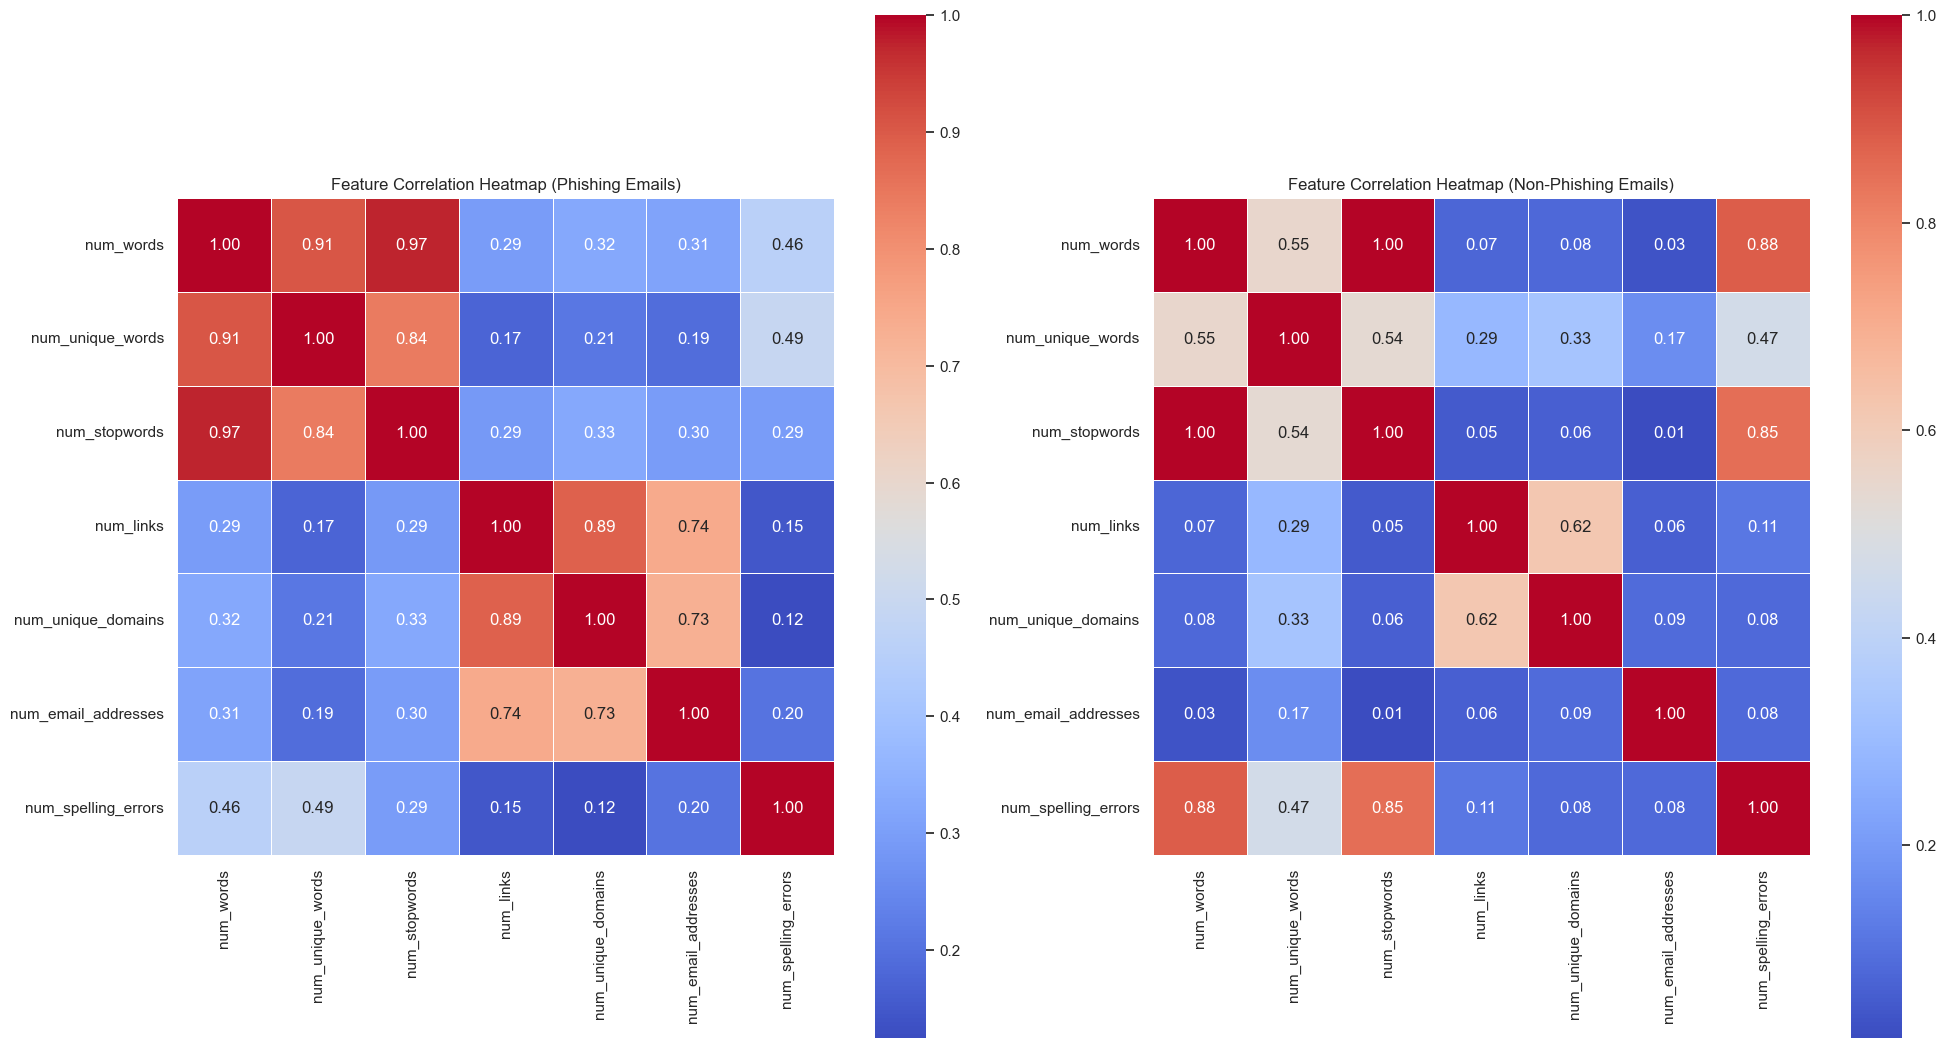

In [60]:
# Calculate the correlation matrix for phishing emails
phishing_corr_matrix = phishing_emails[features].corr()

# Calculate the correlation matrix for non-phishing emails
non_phishing_corr_matrix = non_phishing_emails[features].corr()

# Set up the matplotlib figure for phishing emails
plt.figure(figsize=(20, 14))

for i, dataset in enumerate([phishing_corr_matrix, non_phishing_corr_matrix], 1):
    plt.subplot(1, 2, i)
    if i == 1:
        title = "Phishing Emails"
    else:
        title = "Non-Phishing Emails"

    sns.heatmap(
        dataset,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title(f"Feature Correlation Heatmap ({title})")

plt.savefig("phishing_non_phishing_corr_heatmap.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

1. Strong Word-Based Feature Correlation in Phishing Emails
    * Phishing Emails:
        * num_words, num_unique_words, and num_stopwords are very highly correlated (e.g., 0.91–0.97).
        * Suggests phishing emails tend to have more consistent structure in language, possibly auto-generated or templated.

    * Non-Phishing Emails:
        * Much weaker correlation between these features (0.54–0.55 range).
        * Indicates more linguistic variety in genuine emails (human-written).

    Implication: These features are more interdependent in phishing emails—potential signal for classification.

2. High Link-Related Feature Correlation in Phishing
    * Phishing Emails:
        * num_links, num_unique_domains, and num_email_addresses show strong correlations (0.73–0.89).
        * This may reflect patterns like many emails linking to multiple domains or including spoofed addresses.

    * Non-Phishing:
        * These correlations are much weaker (0.05–0.62), with most values below 0.3.

    Implication: The linking structure in phishing emails is more organized and patterned—could be a red flag.

3. Spelling Errors Behave Differently
    * Phishing:
        * num_spelling_errors has moderate correlation with word count (0.46), possibly due to bulk content generation.

    * Non-Phishing:
        * Surprisingly high correlation (0.88) between num_words and num_spelling_errors.
        * Suggests that longer genuine emails naturally have more chances for minor spelling mistakes.

    Implication: This feature may not be as useful alone but could support other linguistic indicators.

4. Redundancy Watch
    * In phishing emails, some feature pairs (e.g., num_words & num_stopwords) are so highly correlated that one might be redundant in some models (e.g., linear ones).

    * However, in tree-based models (like Random Forest or XGBoost), redundancy is less of a concern.

##### Overall Conclusion
* Phishing emails seem to have more consistent structure in language, possibly due to being auto-generated or templated.

* Spelling errors alone don't necessarily indicate a phishing email as they're present more in non-phishing emails when compared to word count.

* To predict if an email is a phishing email or not, a Random Forest or XGBoost/LightGBM model will be the best fit


# Prediction

## Random Forest Approacch

In [ ]:
# Import necessary libraries for RF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [62]:
X = df.drop(columns='phishing')
y = df['phishing']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [64]:
# Fit model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99    103580\n           1       0.33      0.28      0.30      1390\n\n    accuracy                           0.98    104970\n   macro avg       0.66      0.64      0.65    104970\nweighted avg       0.98      0.98      0.98    104970\n'

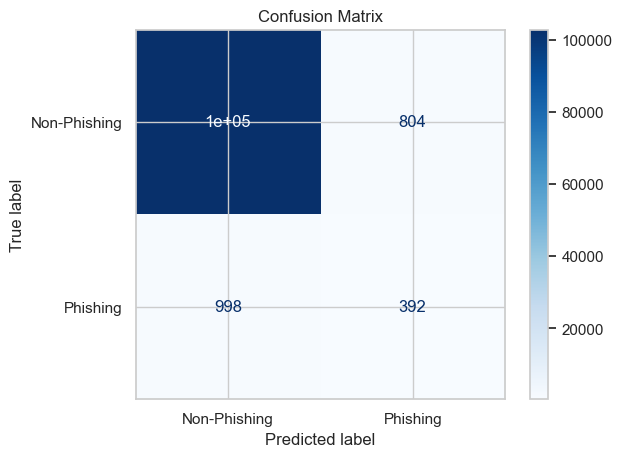

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Non-Phishing", "Phishing"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

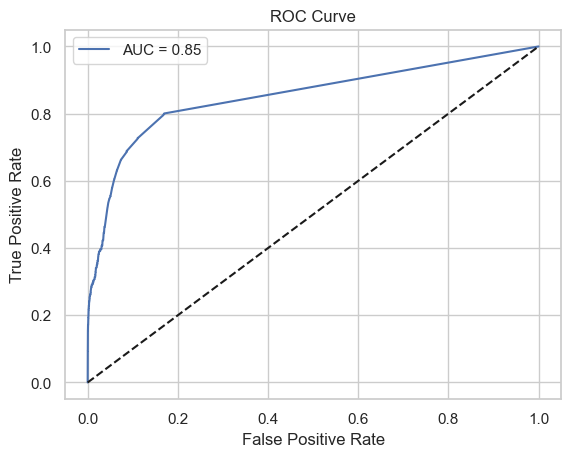

In [69]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

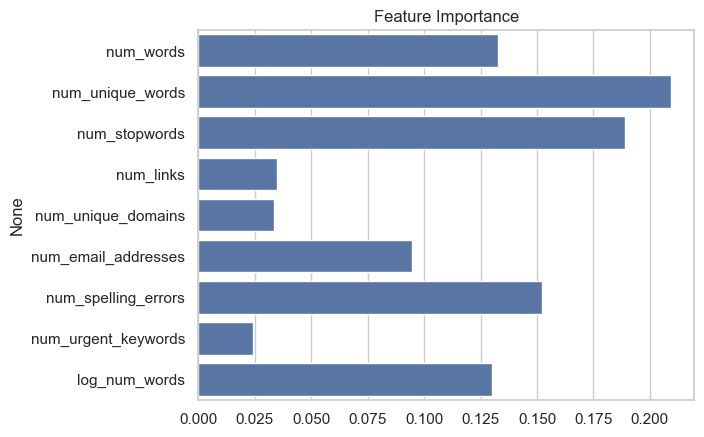

In [65]:
importances = model.feature_importances_
features = X.columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9828
